In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn import metrics
%matplotlib inline

di_MXvideos = pd.read_csv('MXvideos_cc50_202101.csv')
di_MXcategories = pd.read_json('MX_category_id.json')

In [2]:
def fx_porc_missings(data, only_missings = False):

    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)

In [3]:

newdb = di_MXvideos.sort_values(by='likes', ascending=False)
newdb = newdb.drop_duplicates(subset='video_id')
newdb = newdb.dropna(subset=['publish_time'])

categories_dict = {int(item['id']): item['snippet']['title'] for item in di_MXcategories['items']}
newdb['category'] = newdb['category_id'].map(categories_dict)

newdb['comments_disabled'] = newdb['comments_disabled'].map({'FALSO': 0, 'VERDADERO': 1})
newdb['ratings_disabled'] = newdb['ratings_disabled'].map({'FALSO': 0, 'VERDADERO': 1})
newdb['video_error_or_removed'] = newdb['video_error_or_removed'].map({'FALSO': 0, 'VERDADERO': 1})

In [4]:
newdb.to_excel('archivo_exportado.xlsx', index=False)

In [5]:
newdb.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,category
39286,7C2z4GqqS5E,18.20.05,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10.0,18/05/2018 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390.0,4470923.0,119053.0,...,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,0,0,0,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Coahuila,28.329988,-100.849979,POINT (-100.8499789 28.32998781),Music
5580,FlsCjmMhFmw,17.10.12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24.0,06/12/2017 12:58,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",100912384.0,2656698.0,1353667.0,...,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,0,0,0,"YouTube Rewind 2017. Celebrating the videos, p...",Veracruz,17.939976,-94.739990,POINT (-94.73999007 17.93997601),Entertainment
4076,6ZfuNTqbHE8,17.03.12,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24.0,29/11/2017 8:26,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",74789251.0,2444976.0,46173.0,...,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,0,0,0,There was an idea… Avengers: Infinity War. In ...,Sonora,27.580008,-109.929993,POINT (-109.9299931 27.58000775),Entertainment
2561,kTlv5_Bs8aw,17.26.11,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10.0,24/11/2017 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",20573162.0,2320666.0,33228.0,...,https://i.ytimg.com/vi/kTlv5_Bs8aw/default.jpg,0,0,0,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Chiapas,16.749997,-92.633374,POINT (-92.63337447000001 16.74999697),Music
23305,OK3GJ0WIQ8s,18.02.03,j-hope 'Daydream (백일몽)' MV,ibighit,10.0,01/03/2018 10:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",10695328.0,2050610.0,14718.0,...,https://i.ytimg.com/vi/OK3GJ0WIQ8s/default.jpg,0,0,0,j-hope 'Daydream (백일몽)'\n\n\nj-hope's 'Daydrea...,Sinaloa,23.199991,-106.230038,POINT (-106.2300381 23.19999086),Music


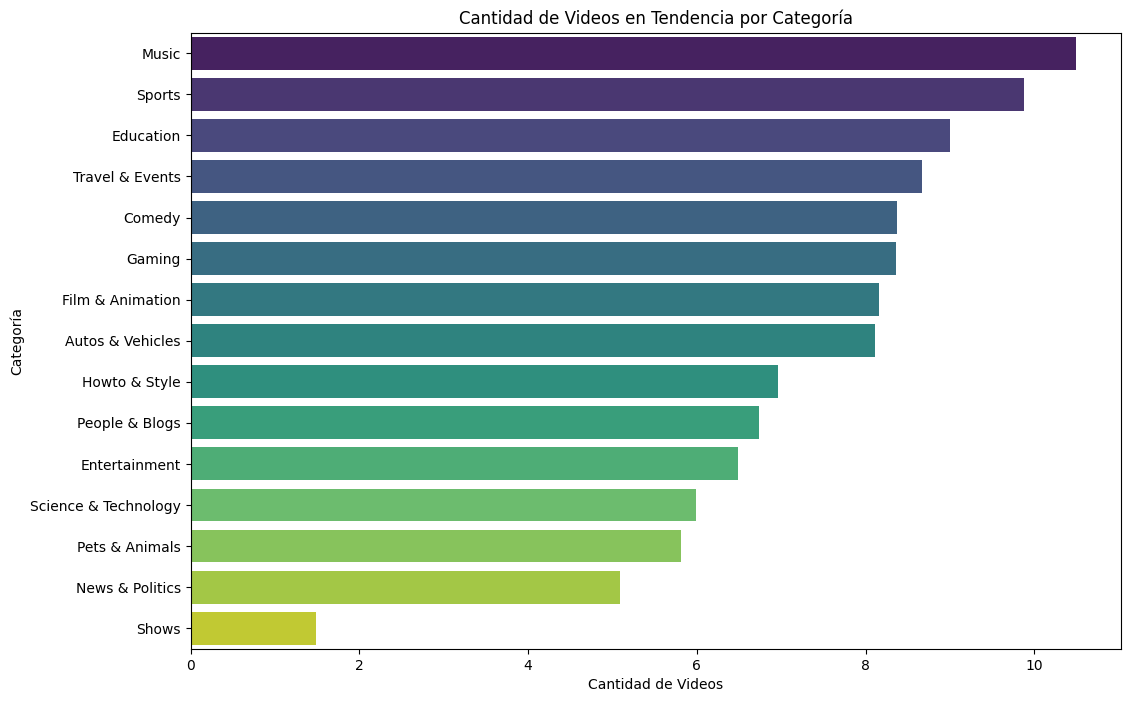

In [6]:


# Agrupar por categoría y calcular la suma de likes y comentarios para cada categoría
agrupado_por_categoria = newdb.groupby('category').agg({'likes': 'sum', 'comment_count': 'sum'}).reset_index()

# Calcular la tasa de likes por comentarios
agrupado_por_categoria['likes_per_comment'] = agrupado_por_categoria['likes'] / agrupado_por_categoria['comment_count']



agrupado_por_categoria.sort_values(by='likes_per_comment', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='likes_per_comment', y='category', data=agrupado_por_categoria, palette='viridis', hue="category")
plt.title('Cantidad de Videos en Tendencia por Categoría')
plt.xlabel('Cantidad de Videos')
plt.ylabel('Categoría')
plt.show()


In [7]:
fx_porc_missings(newdb)

,n_nulos,%Total
video_id,0,0.000000
trending_date,0,0.000000
title,0,0.000000
channel_title,0,0.000000
category_id,0,0.000000
publish_time,0,0.000000
tags,0,0.000000
views,0,0.000000
likes,0,0.000000
dislikes,0,0.000000


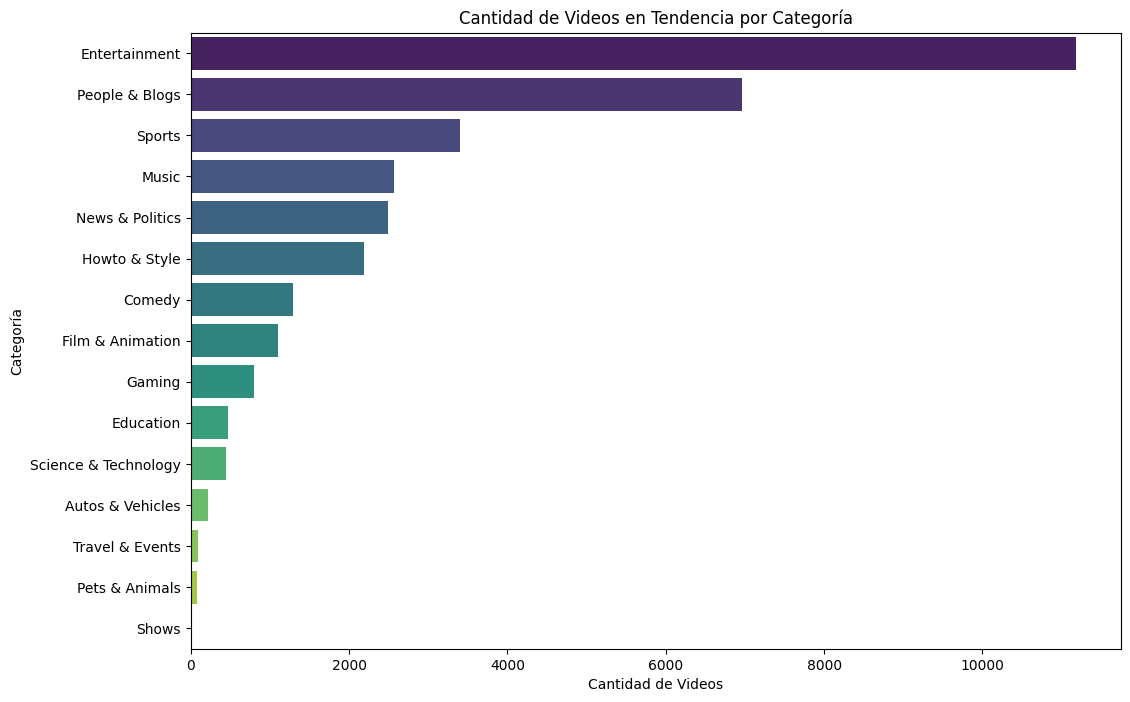

In [8]:
category_counts = newdb['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Graficar las categorías más comunes usando seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='category', data=category_counts, palette='viridis', hue="category")
plt.title('Cantidad de Videos en Tendencia por Categoría')
plt.xlabel('Cantidad de Videos')
plt.ylabel('Categoría')
plt.show()


In [9]:
temp = pd.DataFrame(newdb)
# Convertir la columna de texto 'geometry' en objetos shapely.geometry.Point
temp['geometry'] = temp['geometry'].apply(lambda x: Point(map(float, x.strip('POINT ()').split())))

# Crear el GeoDataFrame
gdf = gpd.GeoDataFrame(temp, geometry='geometry')

centroides = gdf.groupby('state').geometry.apply(lambda x: x.unary_union.centroid)

# Calcular la suma de likes en cada estado
likes_por_estado = gdf.groupby('state').likes.sum().reset_index(name='total_likes')

# Combinar los centroides y la cantidad de likes por estado
centroides_gdf = gpd.GeoDataFrame(geometry=centroides.values, crs=gdf.crs)
centroides_gdf['state'] = centroides.index
centroides_gdf = centroides_gdf.merge(likes_por_estado, on='state')

# Normalizar los likes para asignar colores
max_likes = centroides_gdf['total_likes'].max()
min_likes = centroides_gdf['total_likes'].min()
centroides_gdf['color'] = centroides_gdf['total_likes']

# Calcular las coordenadas medias para centrar el mapa
mean_lat = centroides_gdf.geometry.y.mean()
mean_lon = centroides_gdf.geometry.x.mean()

# Crear un mapa de folium centrado en las coordenadas medias
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

# Añadir los puntos de los centroides al mapa con colores escalados según los likes
colormap = cm.LinearColormap(colors=['#0000FF', '#880088', '#FF0000', '#FF8800', '#FFFF00'], vmin=0, vmax=max_likes)
for _, row in centroides_gdf.iterrows():
    color =  colormap(row["color"])#f'hsl({int(row["color"] * 60)}, 100%, 50%)'  # Escalar el color del punto según los likes
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=10,
        popup=f"{row['state']}: {int(row['total_likes'])} likes",
        fill=True,
        color=color,
        fill_opacity=0.7
    ).add_to(m)
m.add_child(colormap)
m

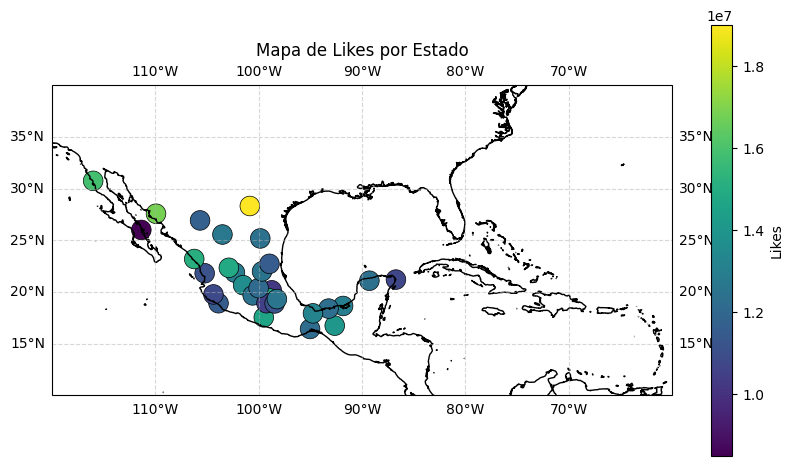

In [10]:
# Crear la figura y los ejes con cartopy

import cartopy.crs as ccrs
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Ajustes para mejorar la visualización
ax.set_extent([-120, -60, 10, 40], crs=ccrs.PlateCarree())  # Extensión del mapa
#ax.background_patch.set_visible(False)  # Ocultar el fondo del mapa

# Agregar puntos al mapa con colores escalados según los likes
sc = ax.scatter(
    centroides_gdf.geometry.x, centroides_gdf.geometry.y,
    c=centroides_gdf['color'], cmap='viridis', s=200,
    transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.5  # Bordes de los puntos
)

# Agregar barra de color (leyenda)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Likes')

# Añadir títulos y etiquetas
ax.set_title('Mapa de Likes por Estado')
ax.coastlines(resolution='10m')  # Líneas de costa más detalladas
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)  # Cuadrícula con etiquetas y estilo

plt.show()

In [11]:
di_MXvideos['category_id'] = di_MXvideos['category_id'].dropna().astype(int)

# Crear el diccionario con id como clave y title como valor
categories_dict = {int(item['id']): item['snippet']['title'] for item in di_MXcategories['items']}

# Reemplazar category_id con su correspondiente title, ignorando los NaN
di_MXvideos['category'] = di_MXvideos['category_id'].map(categories_dict)

# Contar la frecuencia de cada categoría en la lista de videos tendencia
category_counts = di_MXvideos['category'].value_counts()

# Mostrar las categorías más frecuentes (top 5, por ejemplo)
top_categories = category_counts.head(5)
top_categories

category
Entertainment      13487
People & Blogs      8159
Sports              4050
Music               3371
News & Politics     3113
Name: count, dtype: int64

<Axes: xlabel='Category ID'>

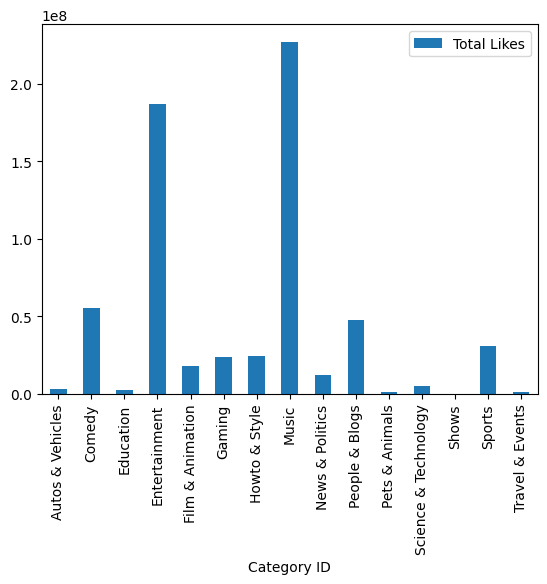

In [12]:


# Agrupar por category_id y sumar los likes
category_likes_sum = di_MXvideos.groupby('category')['likes'].sum().reset_index()

# Renombrar la columna 'category_id' por claridad si es necesario
category_likes_sum = category_likes_sum.rename(columns={'category': 'Category ID', 'likes': 'Total Likes'})
db = pd.DataFrame(category_likes_sum)
#db.plot.bar(x="Category ID", y='Total Likes')
category_likes_sum.plot.bar(x="Category ID", y='Total Likes')

In [13]:
# Convertir category_id a int, manejando los valores NaN
di_MXvideos['category_id'] = di_MXvideos['category_id'].dropna().astype(int)

# Crear el diccionario con id como clave y title como valor
categories_dict = {int(item['id']): item['snippet']['title'] for item in di_MXcategories['items']}

# Reemplazar category_id con su correspondiente title, ignorando los NaN
di_MXvideos['category'] = di_MXvideos['category_id'].map(categories_dict)

category_likes = di_MXvideos.groupby('category')['likes'].mean()

# Ordenar las categorías por media de likes
category_likes_sorted = category_likes.sort_values(ascending=False)

# Mostrar las categorías más y menos populares
most_liked_category = category_likes_sorted.head(1)
least_liked_category = category_likes_sorted.tail(1)

print("Categoría más popular:")
print(category_likes_sorted)

print("\nCategoría menos popular:")
print(least_liked_category)

Categoría más popular:
category
Music                   67343.013942
Comedy                  31729.911596
Gaming                  24147.387324
Entertainment           13842.410840
Film & Animation        13802.194145
Pets & Animals          11933.831325
Autos & Vehicles        11828.940476
Howto & Style            9992.338873
Science & Technology     9631.956685
Travel & Events          7672.726496
Sports                   7621.296543
People & Blogs           5865.798995
Education                4794.421053
News & Politics          3826.024414
Shows                     163.666667
Name: likes, dtype: float64

Categoría menos popular:
category
Shows    163.666667
Name: likes, dtype: float64


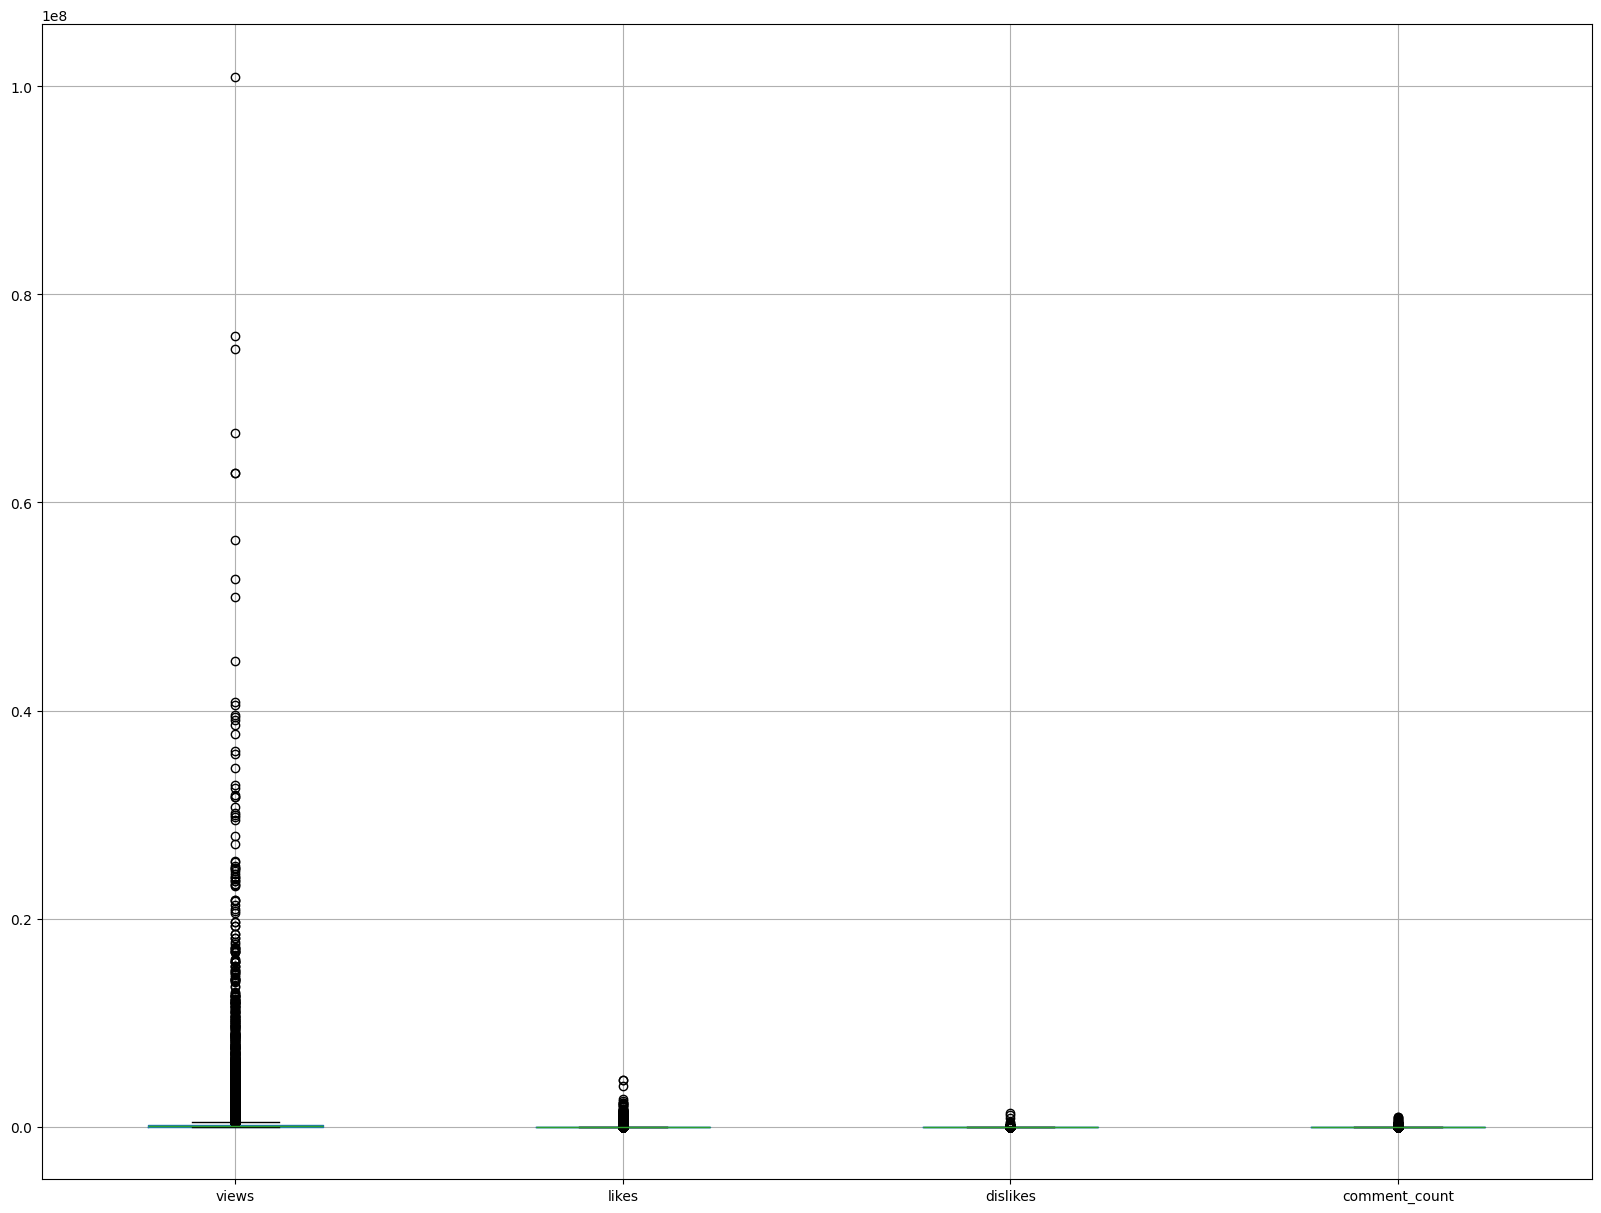

In [14]:
# Construir un diccionario con id como clave y title como valor
numericas = di_MXvideos.select_dtypes(include=['float64', 'int'])
numericas = numericas.drop(['category_id', 'lat', 'lon'], axis = 1)
numericas.boxplot(figsize=(20,15))
plt.show()

In [15]:
di_MXvideos.info()
di_MXcategories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44043 entries, 0 to 44042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                43959 non-null  object 
 1   trending_date           40593 non-null  object 
 2   title                   40510 non-null  object 
 3   channel_title           40501 non-null  object 
 4   category_id             40451 non-null  float64
 5   publish_time            40451 non-null  object 
 6   tags                    40480 non-null  object 
 7   views                   40451 non-null  float64
 8   likes                   40451 non-null  float64
 9   dislikes                40451 non-null  float64
 10  comment_count           40451 non-null  float64
 11  thumbnail_link          40471 non-null  object 
 12  comments_disabled       40451 non-null  object 
 13  ratings_disabled        40451 non-null  object 
 14  video_error_or_removed  40451 non-null

In [16]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)
di_MXvideos.describe()

,category_id,views,likes,dislikes,comment_count,lat,lon
count,40451.000,40451.000,40451.000,40451.000,40451.000,44043.000,44043.000
mean,21.003,342381.968,15861.837,747.160,2039.660,21.482,-100.242
std,5.879,1714690.681,81089.869,10953.577,13938.032,3.502,6.018
min,1.000,157.000,0.000,0.000,0.000,16.430,-116.009
25%,20.000,16813.000,299.000,17.000,42.000,18.920,-103.500
50%,24.000,56973.000,1246.000,63.000,196.000,20.380,-99.670
75%,24.000,206894.000,7226.000,267.000,885.000,22.733,-98.230
max,43.000,100912384.000,4470923.000,1353667.000,905925.000,30.764,-86.711


In [17]:
fx_porc_missings(di_MXvideos).sort_values('%Total')

,n_nulos,%Total
lon,0,0.000
lat,0,0.000
state,0,0.000
geometry,0,0.000
video_id,84,0.191
trending_date,3450,7.833
title,3533,8.022
channel_title,3542,8.042
tags,3563,8.090
thumbnail_link,3572,8.110


In [18]:
db.head()

,Category ID,Total Likes
0,Autos & Vehicles,2980893.000
1,Comedy,55273506.000
2,Education,2550632.000
3,Entertainment,186692595.000
4,Film & Animation,17915248.000


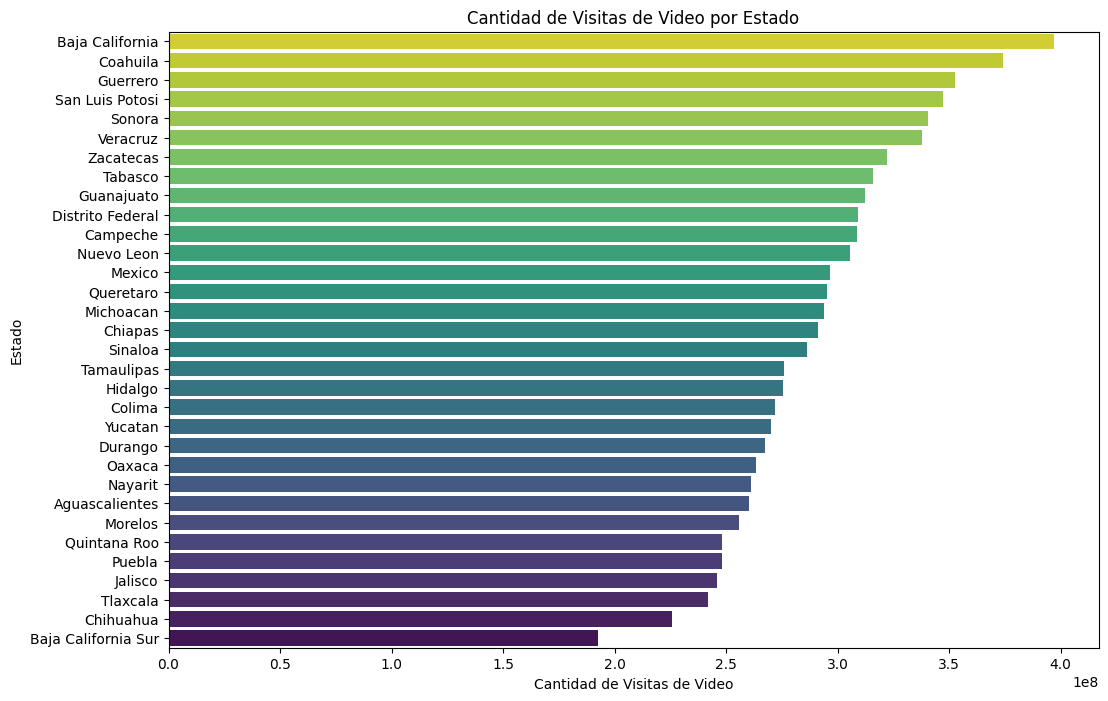

In [19]:
# Paso 2: Agrupar los datos por estado
visits_by_state = newdb.groupby('state')['views'].sum().reset_index()
visits_by_state.sort_values(by='views', inplace=True, ascending=False)


custom_palette = sns.color_palette("viridis", len(visits_by_state))[::-1]

# Visualizar en un gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x='views', y='state', data=visits_by_state, palette=custom_palette, hue="state")
plt.title('Cantidad de Visitas de Video por Estado')
plt.xlabel('Cantidad de Visitas de Video')
plt.ylabel('Estado')
plt.show()

In [20]:
newdb.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,category
39286,7C2z4GqqS5E,18.20.05,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10.000,18/05/2018 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390.000,4470923.000,119053.000,...,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,0,0,0,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Coahuila,28.330,-100.850,POINT (-100.8499789 28.32998781),Music
5580,FlsCjmMhFmw,17.10.12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24.000,06/12/2017 12:58,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",100912384.000,2656698.000,1353667.000,...,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,0,0,0,"YouTube Rewind 2017. Celebrating the videos, p...",Veracruz,17.940,-94.740,POINT (-94.73999007 17.93997601),Entertainment
4076,6ZfuNTqbHE8,17.03.12,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24.000,29/11/2017 8:26,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",74789251.000,2444976.000,46173.000,...,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,0,0,0,There was an idea… Avengers: Infinity War. In ...,Sonora,27.580,-109.930,POINT (-109.9299931 27.58000775),Entertainment
2561,kTlv5_Bs8aw,17.26.11,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10.000,24/11/2017 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",20573162.000,2320666.000,33228.000,...,https://i.ytimg.com/vi/kTlv5_Bs8aw/default.jpg,0,0,0,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Chiapas,16.750,-92.633,POINT (-92.63337447000001 16.74999697),Music
23305,OK3GJ0WIQ8s,18.02.03,j-hope 'Daydream (백일몽)' MV,ibighit,10.000,01/03/2018 10:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",10695328.000,2050610.000,14718.000,...,https://i.ytimg.com/vi/OK3GJ0WIQ8s/default.jpg,0,0,0,j-hope 'Daydream (백일몽)'\n\n\nj-hope's 'Daydrea...,Sinaloa,23.200,-106.230,POINT (-106.2300381 23.19999086),Music


MODEL TRAINING

In [21]:
newnewdb = newdb

newnewdb['description'] = newnewdb['description'].apply(lambda x: 1 if pd.notna(x) else 0)

newnewdb.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,category
39286,7C2z4GqqS5E,18.20.05,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10.000,18/05/2018 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390.000,4470923.000,119053.000,...,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,0,0,0,1,Coahuila,28.330,-100.850,POINT (-100.8499789 28.32998781),Music
5580,FlsCjmMhFmw,17.10.12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24.000,06/12/2017 12:58,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",100912384.000,2656698.000,1353667.000,...,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,0,0,0,1,Veracruz,17.940,-94.740,POINT (-94.73999007 17.93997601),Entertainment
4076,6ZfuNTqbHE8,17.03.12,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24.000,29/11/2017 8:26,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",74789251.000,2444976.000,46173.000,...,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,0,0,0,1,Sonora,27.580,-109.930,POINT (-109.9299931 27.58000775),Entertainment
2561,kTlv5_Bs8aw,17.26.11,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10.000,24/11/2017 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",20573162.000,2320666.000,33228.000,...,https://i.ytimg.com/vi/kTlv5_Bs8aw/default.jpg,0,0,0,1,Chiapas,16.750,-92.633,POINT (-92.63337447000001 16.74999697),Music
23305,OK3GJ0WIQ8s,18.02.03,j-hope 'Daydream (백일몽)' MV,ibighit,10.000,01/03/2018 10:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",10695328.000,2050610.000,14718.000,...,https://i.ytimg.com/vi/OK3GJ0WIQ8s/default.jpg,0,0,0,1,Sinaloa,23.200,-106.230,POINT (-106.2300381 23.19999086),Music


In [22]:
newnewdb.dtypes

video_id                   object
trending_date              object
title                      object
channel_title              object
category_id               float64
publish_time               object
tags                       object
views                     float64
likes                     float64
dislikes                  float64
comment_count             float64
thumbnail_link             object
comments_disabled           int64
ratings_disabled            int64
video_error_or_removed      int64
description                 int64
state                      object
lat                       float64
lon                       float64
geometry                   object
category                   object
dtype: object

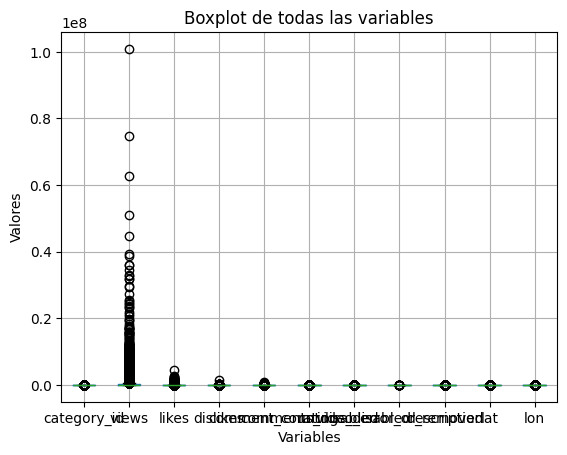

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,category
39286,7C2z4GqqS5E,18.20.05,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10.000,18/05/2018 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390.000,4470923.000,119053.000,...,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,0,0,0,1,Coahuila,28.330,-100.850,POINT (-100.8499789 28.32998781),Music
5580,FlsCjmMhFmw,17.10.12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24.000,06/12/2017 12:58,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",100912384.000,2656698.000,1353667.000,...,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,0,0,0,1,Veracruz,17.940,-94.740,POINT (-94.73999007 17.93997601),Entertainment
4076,6ZfuNTqbHE8,17.03.12,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24.000,29/11/2017 8:26,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",74789251.000,2444976.000,46173.000,...,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,0,0,0,1,Sonora,27.580,-109.930,POINT (-109.9299931 27.58000775),Entertainment
2561,kTlv5_Bs8aw,17.26.11,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10.000,24/11/2017 4:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",20573162.000,2320666.000,33228.000,...,https://i.ytimg.com/vi/kTlv5_Bs8aw/default.jpg,0,0,0,1,Chiapas,16.750,-92.633,POINT (-92.63337447000001 16.74999697),Music
23305,OK3GJ0WIQ8s,18.02.03,j-hope 'Daydream (백일몽)' MV,ibighit,10.000,01/03/2018 10:00,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",10695328.000,2050610.000,14718.000,...,https://i.ytimg.com/vi/OK3GJ0WIQ8s/default.jpg,0,0,0,1,Sinaloa,23.200,-106.230,POINT (-106.2300381 23.19999086),Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23317,QBAnPnI72oo,18.02.03,enamorándonos capítulo completo 28 de febrero ...,Jm Global,24.000,28/02/2018 21:53,[none],9090.000,0.000,0.000,...,https://i.ytimg.com/vi/QBAnPnI72oo/default.jpg,0,1,0,0,Durango,25.570,-103.500,POINT (-103.5000238 25.57005292),Entertainment
23104,1Dr0Mfy_Uic,18.01.03,La Ultima de Enamorandonos 28 de Febrero 2018,Americalcio,29.000,28/02/2018 21:23,"Enamorandonos La Ultima|""Enamorandonos En Vivo...",4418.000,0.000,0.000,...,https://i.ytimg.com/vi/1Dr0Mfy_Uic/default.jpg,0,1,0,0,Mexico,19.410,-99.030,POINT (-99.02998660999999 19.41001548),NaN
1111,1bqAMbitgHY,17.19.11,Jefe Encubierto 2017 h&h Cadena de Jochos,Neza,29.000,18/11/2017 8:41,"Jefe Encubierto 2017|""Jefe Encubierto En Españ...",10979.000,0.000,0.000,...,https://i.ytimg.com/vi/1bqAMbitgHY/default.jpg,0,1,0,1,Veracruz,17.940,-94.740,POINT (-94.73999007 17.93997601),NaN
23250,VfCa9Cp62iw,18.01.03,Bebeshita y Oscar se besan frente Alexia! Desc...,MyWorld,24.000,26/02/2018 9:25,[none],1592.000,0.000,0.000,...,https://i.ytimg.com/vi/VfCa9Cp62iw/default.jpg,0,1,0,0,Veracruz,17.940,-94.740,POINT (-94.73999007 17.93997601),Entertainment


In [23]:
newnewdb.drop([], axis=1).boxplot()
plt.title('Boxplot de todas las variables')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()
newnewdb

In [24]:
newnewdb = newnewdb[(newnewdb['ratings_disabled'] != 1) & (newnewdb['comments_disabled'] != 1)]
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Seleccionar las columnas numéricas y eliminar las no deseadas
numeric_columns = newnewdb.select_dtypes(include=[np.number]).drop(["video_error_or_removed", "ratings_disabled", "description", "category_id", "lat", "lon"], axis=1).columns

replace_outliers_with_median(newnewdb, 'views')
# Reemplazar outliers en todas las columnas numéricas con la mediana
for column in numeric_columns:
    newnewdb = replace_outliers_with_median(newnewdb, column)

In [25]:
x = newnewdb.select_dtypes(include=[np.number]).drop(["views", "lat", "lon", "video_error_or_removed", "category_id", 'ratings_disabled'], axis=1)
y = newnewdb['views']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=101)

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [28]:
lr.fit(x_train, y_train)

LinearRegression()

In [29]:
predictions = lr.predict(x_test)

Text(0, 0.5, 'Y Predichos')

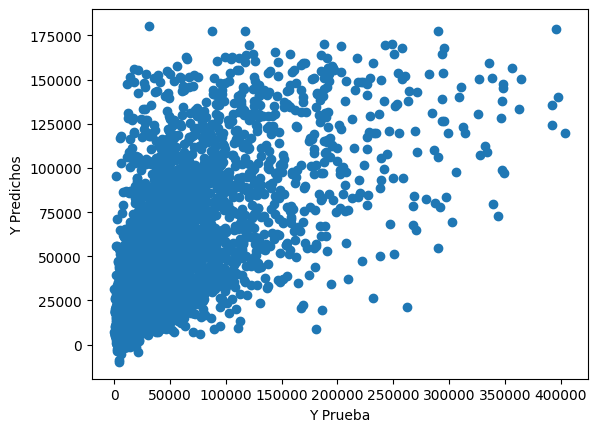

In [30]:
plt.scatter(y_test, predictions)
plt.xlabel('Y Prueba')
plt.ylabel('Y Predichos')

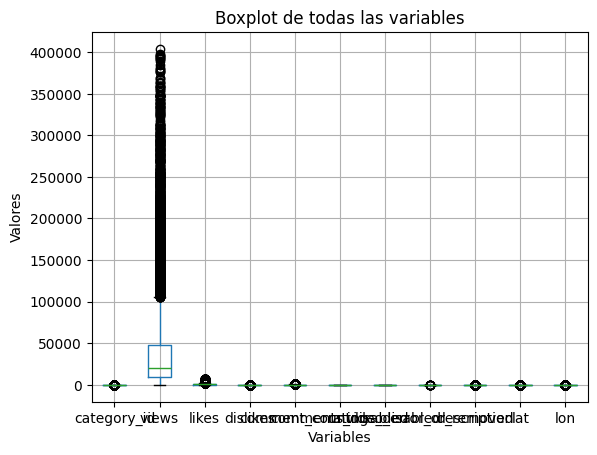

In [31]:
newnewdb.drop([], axis=1).boxplot()
plt.title('Boxplot de todas las variables')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()

,Coeficiente
category_id,-8.629
views,0.001
dislikes,2.801
comment_count,5.786
comments_disabled,0.000
ratings_disabled,0.000
description,136.029


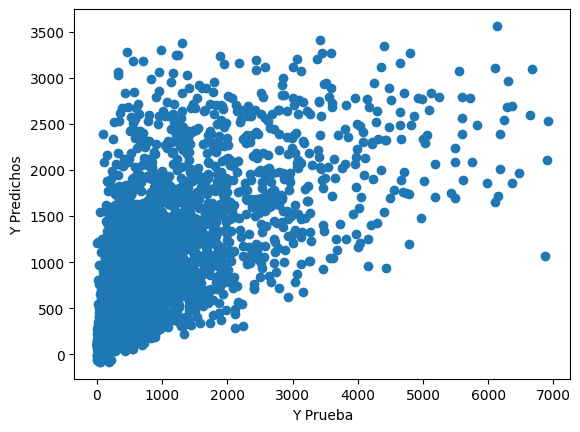

In [32]:
x = newnewdb.select_dtypes(include=[np.number]).drop(["likes", "lat", "lon", "video_error_or_removed"], axis=1)
y = newnewdb['likes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
plt.scatter(y_test, predictions)
plt.xlabel('Y Prueba')
plt.ylabel('Y Predichos')

lr.coef_ = pd.DataFrame(lr.coef_,x.columns,columns=['Coeficiente'])
lr.coef_ 

In [33]:
newnewdb.select_dtypes(include=[np.number]).drop(["dislikes", "lat", "lon", "video_error_or_removed", 'ratings_disabled', 'comments_disabled', "description", "category_id"], axis=1)

,views,likes,comment_count
20199,97493.000,6915.000,347.000
40022,51835.000,6911.000,223.000
20365,250084.000,6910.000,375.000
43107,120447.000,6897.000,238.000
41801,114274.000,6895.000,335.000
...,...,...,...
476,3786.000,1.000,0.000
16891,180466.000,0.000,186.000
342,2978.000,0.000,3.000
552,3632.000,0.000,12.000


MAE: 16.343454743112176
MSE: 567.7096935295796
RMSE: 23.82665930275538


169384035306.38937

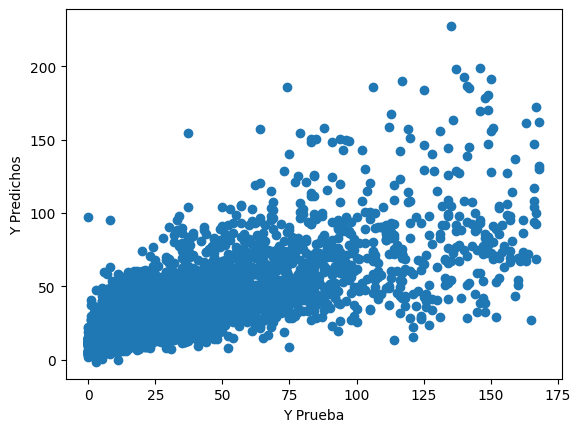

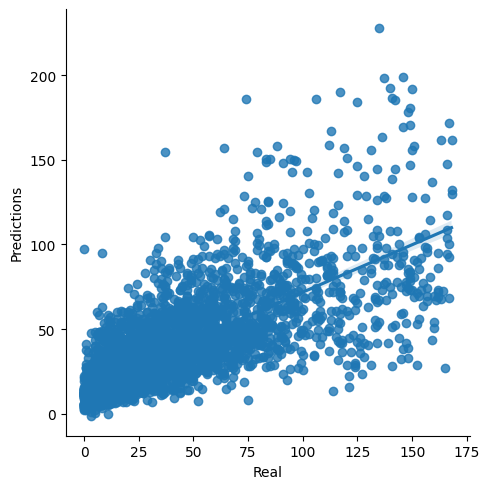

In [34]:
x = newnewdb.select_dtypes(include=[np.number]).drop(["dislikes", "lat", "lon", "video_error_or_removed"], axis=1)
y = newnewdb['dislikes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
plt.scatter(y_test, predictions)
plt.xlabel('Y Prueba')
plt.ylabel('Y Predichos')

lr.coef_ = pd.DataFrame(lr.coef_,x.columns,columns=['Coeficiente'])
lr.coef_ 

# calcular estas métricas a mano!
def MAE(y_t, y_p):
    res = 0
    for i in range(len(y_t)):
        res += abs(y_t.iloc[i] - y_p[i])
    res /= len(y_t)
    return res

def MSE(y_t, y_p):
    res = 0
    for i in range(len(y_t)):
        res += pow((y_t.iloc[i] - y_p[i]), 2)
    res /= len(y_t)
    return res

def RMSE(y_t, y_p):
    res = 0
    for i in range(len(y_t)):
        res += pow((y_t.iloc[i] - y_p[i]), 2)
    res /= len(y_t)
    res = pow(res, 1/2)
    return res

print("MAE:", MAE(y_test,predictions))
print("MSE:", MSE(y_test,predictions))
print("RMSE:", RMSE(y_test,predictions))

data = pd.DataFrame({
    'Real': y_test,
    'Predictions': predictions
})
sns.lmplot(x='Real', y='Predictions', data=data)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Añadir 1 para evitar divisiones por cero
    y_true = y_true + 1e-10
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
mape

MAE: 20923.678757860587
MSE: 1301751708.6232526
RMSE: 36079.79640495845


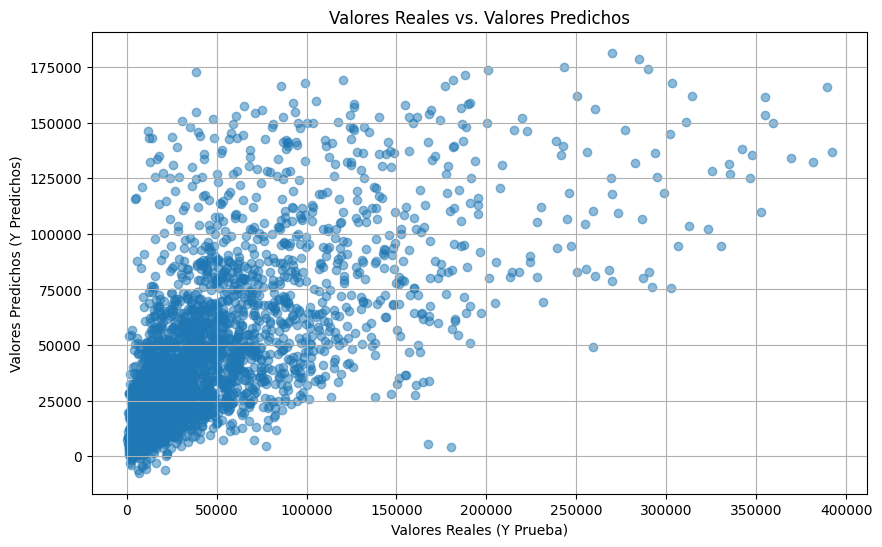

In [35]:
x = newnewdb.select_dtypes(include=[np.number]).drop(["views", "lat", "lon", "video_error_or_removed"], axis=1)
y = newnewdb["views"]

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión lineal
lr = LinearRegression()
lr.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions = lr.predict(x_test)


print("MAE:", MAE(y_test,predictions))
print("MSE:", MSE(y_test,predictions))
print("RMSE:", RMSE(y_test,predictions))

# Graficar las predicciones contra los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Valores Reales (Y Prueba)')
plt.ylabel('Valores Predichos (Y Predichos)')
plt.title('Valores Reales vs. Valores Predichos')
plt.grid(True)
plt.show()